### Overview

Amidst the controversy of AI generated artwork, a question less discussed is whether AI has the capacity to interpret art. My goal with this project is to understand if it's possible to build a neural network that can determine the emotional valence of a piece of art based on the colors used to create this art. 

Before jumping into this, it would be helpful to define exactly what we're measuring here. According to [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4098114/#:~:text=Emotional%20valence%20describes%20the%20extent,1997%3B%20Russell%2C%202003), emotional valence "describes the extent to which an emotion is positive or negative". This provides us with some direction on how to define the scope of this project. The aim here will be to create a binary classifier to predict either positive or negative valence. It's also worth noting that I'm focusing this project on traditional paintings since there are so many different artistic mediums we could delve into.

### Data Processing

Along with importing TensorFlow and some typical image processing libraries, I'm also importing a library called ColorThief, which will analyze an image and extract the *n* most used colors.

In [2]:
import os
import sys
import numpy as np
import cv2
import imghdr
import random
import colorsys

from matplotlib import pyplot as plt
from skimage import io

from colorthief import ColorThief

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dense, Flatten, Reshape, InputLayer
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras import backend as K

tf.config.run_functions_eagerly(True)

For demonstration purposes, I created a couple of functions to extract colors from an image and plot those colors in order of importance, as seen in the image below.

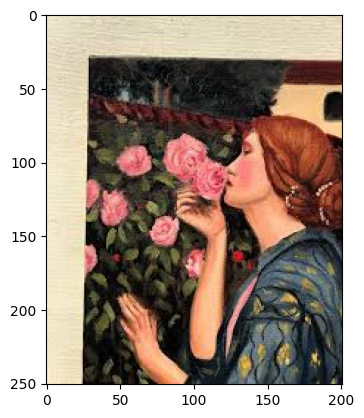

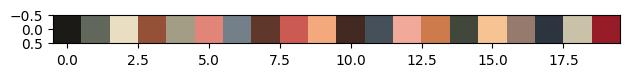

In [3]:
def generate_color_scheme(file, num_colors=6):
    # creates list of rgb tuples
    color_thief = ColorThief(file)
    palette = color_thief.get_palette(num_colors+1, quality=10)
    return palette

def plot_colors(palette):
    # plots all colors on single axis
    int_palette = np.uint8([palette])
    io.imshow(int_palette)

file = '/content/drive/MyDrive/painting_valence/paintings_dataset/high_val_paintings/images103.jpg'

# import and display test image
img = cv2.imread(file)
# reorder red, blue, green configuration (only required for viewing)
frame_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(frame_rgb)
plt.show()

plot_colors(generate_color_scheme(file, num_colors=20))

Now is a good time to talk about the data collection strategy for this project. Since we're interested in classifying paintings into two categories, I took a fairly straightforward approach to data collection by scraping images from Google Images with terms like "happy painting", "joyful painting", "depressing painting", etc. I stored these in two folders, labeled with high (positive) and low (negative) valence.

Each of these images can then be run through the color palette generating function created above to pull the 20 most used colors for each painting.

In [6]:
palettes = []
target = []

high_val_dir = '/content/drive/MyDrive/painting_valence/paintings_dataset/high_val_paintings/'
low_val_dir = '/content/drive/MyDrive/painting_valence/paintings_dataset/low_val_paintings/'

# iterate through images, append color scheme for each image to list
for image_class in os.listdir(high_val_dir):
    image_path = os.path.join(high_val_dir, image_class)
    palettes.append(generate_color_scheme(image_path, num_colors=20))
    target.append(1)

for image_class in os.listdir(low_val_dir):
    image_path = os.path.join(low_val_dir, image_class)
    palettes.append(generate_color_scheme(image_path, num_colors=20))
    target.append(0)
    
# converting lists to arrays
palettes_arr = np.array(palettes, dtype=np.uint8)
targets_arr = np.array(target, np.uint8)
targets_arr = targets_arr.reshape(targets_arr.shape[0], 1)

# reformatting nested lists, converting back to array
palette_list = []
for palette in palettes:
  color_list = []
  for rgb in palette:
    color_list.append([colorsys.rgb_to_hsv(rgb[0], rgb[1], rgb[2])])
  palette_list.append(color_list)

palettes_arr3 = np.array(palette_list)
palettes_arr3 = palettes_arr.reshape(palettes_arr.shape[0], 20, 1, 3)

# normalizing color values from 0-255 to 0-1
palettes_arr3 = palettes_arr3/255

The last step to take care of is splitting our data into training and testing partitions. In this case, I'll be using a training and validation split during the model creation process, and a testing partition for the final evaluation of the model. This helps to ensure the model will perform well on data it has not seen during any stage of the process.

In [8]:
def train_test_split(X, y, percentage):
  train_percentage = percentage
  train_k = len(X) * train_percentage // 100
  train_indicies = random.sample(range(len(X)), train_k)

  X_train = X[train_indicies]
  y_train = y[train_indicies]

  test_mask = np.ones(len(X), dtype=bool)
  test_mask[train_indicies] = False
  X_test = X[test_mask]
  y_test = y[test_mask]

  return X_train, X_test, y_train, y_test

# 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(palettes_arr3, targets_arr, 60)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 50)

### Model Training

With our data ready to go, we can switch focus to setting up our neural network. While our classes are very balanced, I still want to use F1 score here just to be certain that we're getting accurate predictions from each class. 

Since TensorFlow does not support F1 score out of the box, I've used a custom metric defined below.

In [9]:
def f1(y_true, y_pred):
    # Define the true positives, false positives and false negatives
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate the precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate the F1 score
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    return f1_score

Here we're skipping forward in time a bit. I got stuck for a while here with the architecture of the model. Originally I tried using only dense layers and as simple a model as possible, but regardless of the configuration chosen, could not get validation F1 score higher than the mid 60's, which was not acceptable in this context.

The configuration shown here is my last attempt before moving on to other strategies, and as shown, did not perform strongly.

In [10]:
model_1 = Sequential()

model_1.add(Conv2D(16, (3,1), 1, activation='relu', input_shape=(20,1,3)))
model_1.add(MaxPooling2D(pool_size=(3,1)))
model_1.add(Flatten())
model_1.add(Dense(256, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

model_1.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=[f1])

In [11]:
hist = model_1.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=50)

Epoch 1/50
15/15 [==============================] - 2s 73ms/step - loss: 0.6894 - f1: 0.6272 - val_loss: 0.6931 - val_f1: 0.4814
Epoch 2/50
15/15 [==============================] - 1s 48ms/step - loss: 0.6825 - f1: 0.6411 - val_loss: 0.6869 - val_f1: 0.6252
Epoch 3/50
15/15 [==============================] - 1s 45ms/step - loss: 0.6718 - f1: 0.6214 - val_loss: 0.6890 - val_f1: 0.5929
Epoch 4/50
15/15 [==============================] - 1s 47ms/step - loss: 0.6721 - f1: 0.6652 - val_loss: 0.6952 - val_f1: 0.5578
Epoch 5/50
15/15 [==============================] - 1s 45ms/step - loss: 0.6771 - f1: 0.3241 - val_loss: 0.6917 - val_f1: 0.6514
Epoch 6/50
15/15 [==============================] - 1s 45ms/step - loss: 0.6705 - f1: 0.6910 - val_loss: 0.6944 - val_f1: 0.5794
Epoch 7/50
15/15 [==============================] - 1s 63ms/step - loss: 0.6653 - f1: 0.4484 - val_loss: 0.6937 - val_f1: 0.5920
Epoch 8/50
15/15 [==============================] - 1s 66ms/step - loss: 0.6622 - f1: 0.6676 - va

Going back to the drawing board, I started to wonder if maybe the colors themselves were just not enough information to make these predictions reliably. Perhaps there were other components of a painting that more accurately determine valence, or maybe the relationship between colors in space are far more important than the colors themselves.

After spending some time diving into CNN's designed for processing color images, I found [this repo](https://github.com/nicknochnack/ImageClassification/tree/main) which had a script for processing and classifying the emotion on people's faces. (As a side note, I'm not sure exactly why this problem needs color images.) 

Regardless, I prepared the images to be processed by TensorFlow, and tried out the architecture just as presented in the repo and got the results displayed below.

In [12]:
# import image data
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/painting_valence/paintings_dataset')
data = data.map(lambda x,y: (x/255, y))

# partition data (70% train, 20% validation, 10% test)
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

Found 795 files belonging to 2 classes.


In [14]:
model_2 = Sequential()

model_2.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model_2.add(MaxPooling2D())
model_2.add(Conv2D(32, (3,3), 1, activation='relu'))
model_2.add(MaxPooling2D())
model_2.add(Conv2D(16, (3,3), 1, activation='relu'))
model_2.add(MaxPooling2D())
model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

model_2.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=[f1])

hist = model_2.fit(train, epochs=20, validation_data=val)

Epoch 1/20
17/17 [==============================] - 60s 3s/step - loss: 0.9170 - f1: 0.2263 - val_loss: 0.7023 - val_f1: 0.6454
Epoch 2/20
17/17 [==============================] - 55s 3s/step - loss: 0.7009 - f1: 0.3768 - val_loss: 0.6902 - val_f1: 0.5292
Epoch 3/20
17/17 [==============================] - 56s 3s/step - loss: 0.6833 - f1: 0.5117 - val_loss: 0.7139 - val_f1: 0.0500
Epoch 4/20
17/17 [==============================] - 58s 3s/step - loss: 0.6594 - f1: 0.5423 - val_loss: 0.6254 - val_f1: 0.7231
Epoch 5/20
17/17 [==============================] - 53s 3s/step - loss: 0.5896 - f1: 0.6614 - val_loss: 0.5834 - val_f1: 0.6419
Epoch 6/20
17/17 [==============================] - 58s 3s/step - loss: 0.5704 - f1: 0.6648 - val_loss: 0.5505 - val_f1: 0.6519
Epoch 7/20
17/17 [==============================] - 55s 3s/step - loss: 0.4984 - f1: 0.7708 - val_loss: 0.5537 - val_f1: 0.7199
Epoch 8/20
17/17 [==============================] - 58s 3s/step - loss: 0.4200 - f1: 0.7981 - val_loss: 

This is a massive difference! Going from a validation F1 score of ~0.65 *at best* to 0.977 is a huge improvement. While I did tinker with the architecture a bit more, this was the highest I was able to achieve (not that I'm disappointed.) Next I wanted to ensure that this performance would be matched by data that the model had not yet seen.

In [15]:
# model_2.save('/content/drive/MyDrive/painting_valence/painting_valence_v2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
# evaluate model on test partition
results = model_2.evaluate(test, batch_size=128)

2/2 [==============================] - 7s 1s/step - loss: 0.1725 - f1: 0.9487


Reviewing the F1 score for our test data (0.949), it's clear that our model is performing well on new data. It's also nice to see that we're getting a similar score on all three partitions of our data, indicating that we have not overfit our model.

### Conclusion

As a final step, I withheld a couple of examples from all partitions to see this model working in action. I'm very excited to see this model performing as well as it does and already have some additional ideas for some similar projects in the future.

In [17]:
def predict_valence(file_path):
    # import and display image
    img = cv2.imread(file_path)
    frame_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.show()
    
    # resize for model
    resize = tf.image.resize(img, (256,256))
    yhat = model_2.predict(np.expand_dims(resize/255, 0))
    
    # classify 0-1 confidence into high/low valence
    if yhat < .5:
        return 'high'
    else:
        return 'low'

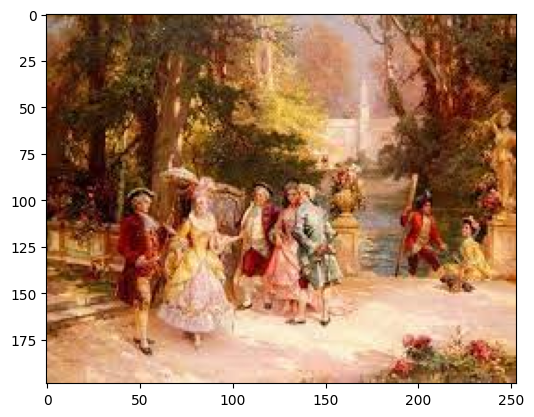

1/1 [==============================] - 0s 128ms/step


'high'

In [18]:
predict_valence('/content/drive/MyDrive/painting_valence/test_paintings/image17.jpeg')

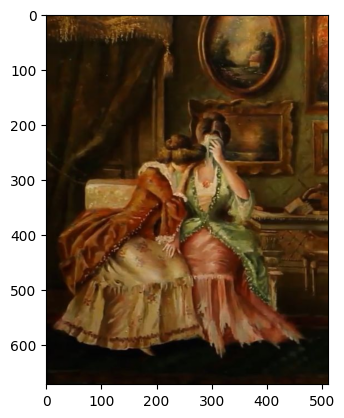

1/1 [==============================] - 0s 48ms/step


'low'

In [19]:
predict_valence('/content/drive/MyDrive/painting_valence/test_paintings/c0ead41153f21784c964e046e76cdfd2.jpg')

Just for fun, I also tried inputting some frames from movies to see how the model would handle them. While I did cherry pick these, this could be the start of an interesting part 2 where we can plot the valence of a film over time by sampling frames throughout its duration.

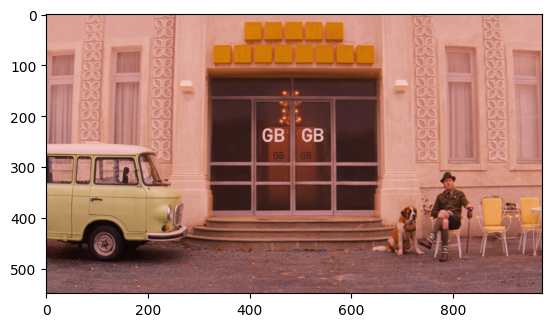

1/1 [==============================] - 0s 70ms/step


'high'

In [20]:
predict_valence('/content/drive/MyDrive/painting_valence/test_paintings/film_example_1.jpeg')

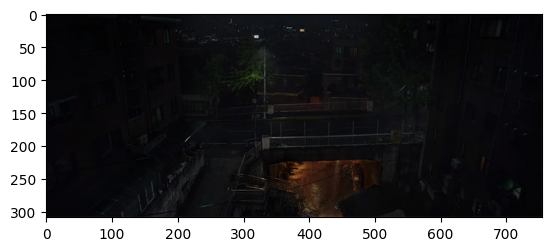

1/1 [==============================] - 0s 66ms/step


'low'

In [21]:
predict_valence('/content/drive/MyDrive/painting_valence/test_paintings/film_example_2.jpeg')